In [1]:
import time
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.precision", 3)
np.set_printoptions(precision=3)
%matplotlib inline

In [2]:
from math import *
from sklearn.metrics import *

import statsmodels.api as sm
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [3]:
import pylab 
import joblib
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [4]:
df_wid = pd.read_csv('Unbinned_final.csv')
df_wid.drop(['Unnamed: 0','ColTime'],axis=1,inplace=True)
df_wid.head()

,Acc,AbsSpd,S,DeltaV,Type-Car,Type-TW,SLType-Car,SLType-TW,Category-Left,Category-NoLead,Category-Right,AccGapWiden-Widening
0,0.754,12.549,11.503,0.092,0,1,0,1,0,1,0,1
1,2.657,11.684,6.135,4.808,0,1,0,1,0,1,0,1
2,1.669,12.311,8.152,0.389,0,1,0,1,0,1,0,1
3,1.258,12.986,12.444,2.004,0,1,0,1,0,1,0,1
4,1.427,12.165,5.068,1.973,0,1,0,1,0,1,0,1


In [5]:
df_bin = df_wid.copy()
bins_interval = {"AbsSpd":0.1}
bins_feat = ['AbsSpd']
for col in bins_feat:
    bins = np.arange(df_bin[col].min(),df_bin[col].max()+bins_interval[col],bins_interval[col])
    def col_bins(x):
        for i in range(len(bins)):
            if x <= bins[i]:
                return i
    
    df_bin[f'{col}_bins'] = df_bin[col].apply(col_bins)
    #df_bin[f'{col}_mean'] = df_bin.groupby(f'{col}_bins')[col].transform('mean')

df_Wbin = df_bin.groupby('AbsSpd_bins').mean().reset_index()
print(df_Wbin.shape)
df_Wbin.tail()

(167, 13)


,AbsSpd_bins,Acc,AbsSpd,S,DeltaV,Type-Car,Type-TW,SLType-Car,SLType-TW,Category-Left,Category-NoLead,Category-Right,AccGapWiden-Widening
162,205,-1.572,20.645,14.163,-1.579,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
163,207,-2.357,20.885,11.629,-2.795,0.0,1.0,0.0,1.0,0.0,0.5,0.5,0.5
164,208,-0.530,20.972,14.712,-8.019,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
165,213,-2.429,21.519,27.785,-4.950,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
166,225,-2.638,22.725,27.889,-10.770,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


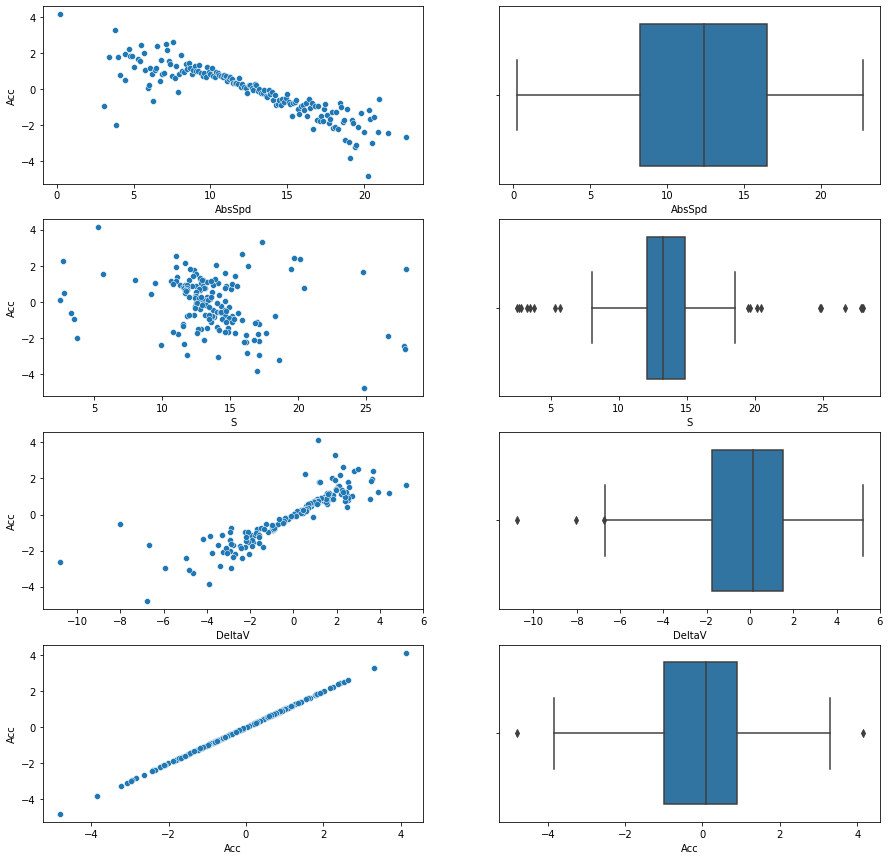

In [6]:
col_list = ['AbsSpd','S','DeltaV','Acc']
fig, axes = plt.subplots(4,2, figsize=(15,15))

for i in range(len(col_list)):
    sns.boxplot    (ax=axes[i,1], data = df_Wbin, x = col_list[i])
    sns.scatterplot(ax=axes[i,0], data = df_Wbin, x = col_list[i], y = 'Acc')

## Model building

In [7]:
X = df_Wbin.drop(['Acc','AbsSpd_bins'],axis=1)
y = df_Wbin['Acc']

attributes = X.columns
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = attributes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=35) ## 55 

xgbr = XGBRegressor(colsample_bytree = 0.8,learning_rate =0.1,max_depth= 15,
        min_child_weight =15,n_estimators = 50,subsample = 0.80,random_state=15)

xgbr.fit(X_train,y_train,early_stopping_rounds=20, eval_set=[(X_test, y_test)], verbose=False)


svr = SVR(kernel='linear')
svr.fit(X_train,y_train)

rf = RandomForestRegressor(random_state=10,n_estimators = 50,
                          max_depth=15, min_samples_leaf=10,min_samples_split=10)
rf.fit(X_train,y_train)

lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [8]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}

In [9]:
xgbr.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 15,
 'min_child_weight': 15,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 50,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 15,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [10]:
X_train

,AbsSpd,S,DeltaV,Type-Car,Type-TW,SLType-Car,SLType-TW,Category-Left,Category-NoLead,Category-Right,AccGapWiden-Widening
64,-0.375,-0.180,0.545,0.870,-1.007,0.531,-0.538,0.041,-0.166,0.177,0.692
113,0.605,0.377,-0.283,0.405,-0.235,-0.096,0.148,-0.033,0.221,-0.176,-0.570
79,-0.074,-0.037,0.280,0.505,-0.613,0.398,-0.383,0.275,-0.144,-0.255,0.179
81,-0.035,-0.108,0.279,0.835,-0.836,0.333,-0.372,0.370,-0.217,-0.147,0.049
142,1.188,0.601,-1.002,1.283,-1.063,0.815,-0.516,-0.426,0.387,0.161,-1.190
...,...,...,...,...,...,...,...,...,...,...,...
57,-0.516,-0.187,0.769,0.013,-0.250,-0.296,0.239,-0.101,-0.079,0.428,1.100
164,1.724,0.269,-3.197,-1.075,1.163,-1.247,1.267,-1.010,-2.465,4.573,-1.511
139,1.126,0.888,-1.454,-0.191,0.328,-0.087,0.264,-1.010,1.278,-0.390,-1.511
33,-0.995,-0.364,0.912,0.693,-2.176,0.299,-0.070,0.303,0.744,-1.099,0.656


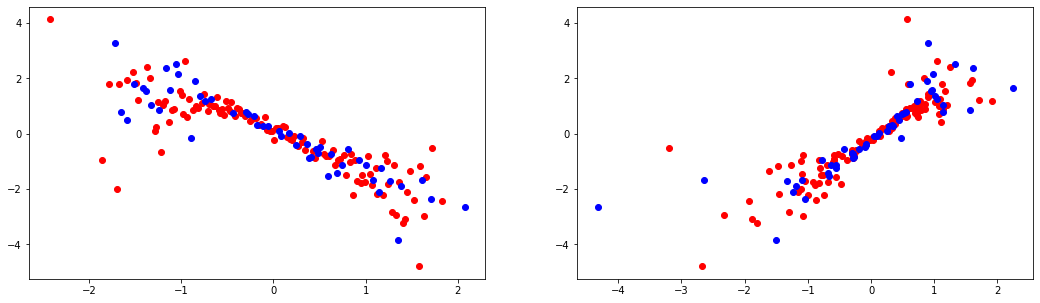

In [11]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.scatter(X_train['AbsSpd'],y_train,c='r')
plt.scatter(X_test['AbsSpd'],y_test,c='b')

plt.subplot(1,2,2)
plt.scatter(X_train['DeltaV'],y_train,c='r')
plt.scatter(X_test['DeltaV'],y_test,c='b')
plt.show()

## Saving the models

In [12]:
joblib.dump(lr,   'lr_bin_com.pkl')
joblib.dump(svr,  'svr_bin_com.pkl')
joblib.dump(rf,   'rf_bin_com.pkl')
joblib.dump(xgbr, 'xgbr_bin_com.pkl')

['xgbr_bin_com.pkl']

In [13]:
xgbr_pred   = xgbr.predict(X_test)
rf_pred     = rf.predict(X_test)
svr_pred    = svr.predict(X_test)
lr_pred     = lr.predict(X_test)

xgbr_train  = xgbr.predict(X_train)
rf_train    = rf.predict(X_train)
svr_train   = svr.predict(X_train)
lr_train    = lr.predict(X_train)


xgbr_R2_T   = xgbr.score(X_train,y_train)
xgbr_R2     = xgbr.score(X_test,y_test)
xgbr_RMSE   = mean_squared_error(y_test,xgbr_pred,squared=False)
xgbr_RMSE_T =mean_squared_error(y_train,xgbr_train,squared=False)
xgbr_MAE    = mean_absolute_error(y_test,xgbr_pred)
xgbr_MAE_T  = mean_absolute_error(y_train,xgbr_train)


rf_R2_T     = rf.score(X_train,y_train)
rf_R2       = rf.score(X_test,y_test)
rf_RMSE     = mean_squared_error(y_test,rf_pred,squared=False)
rf_RMSE_T   = mean_squared_error(y_train,rf_train,squared=False)
rf_MAE      = mean_absolute_error(y_test,rf_pred)
rf_MAE_T    = mean_absolute_error(y_train,rf_train)

svr_R2_T    = svr.score(X_train,y_train)
svr_R2      = svr.score(X_test,y_test)
svr_RMSE    = mean_squared_error(y_test,svr_pred,squared=False)
svr_RMSE_T  = mean_squared_error(y_train,svr_train,squared=False)
svr_MAE     = mean_absolute_error(y_test,svr_pred)
svr_MAE_T   = mean_absolute_error(y_train,svr_train)

lr_R2_T     = lr.score(X_train,y_train)
lr_R2       = lr.score(X_test,y_test)
lr_RMSE     = mean_squared_error(y_test,lr_pred,squared=False)
lr_RMSE_T   = mean_squared_error(y_train,lr_train,squared=False)
lr_MAE      = mean_absolute_error(y_test,lr_pred)
lr_MAE_T    = mean_absolute_error(y_train,lr_train)

dct = {}
dct['XGBR'] = [xgbr_R2_T,xgbr_R2,xgbr_RMSE_T,xgbr_RMSE,xgbr_MAE_T,xgbr_MAE]
dct['RF']   = [rf_R2_T,rf_R2,rf_RMSE_T,rf_RMSE,rf_MAE_T,rf_MAE]
dct['SVR']  = [svr_R2_T,svr_R2,svr_RMSE_T,svr_RMSE,svr_MAE_T,svr_MAE]
dct['LR']   = [lr_R2_T,lr_R2,lr_RMSE_T,lr_RMSE,lr_MAE_T,lr_MAE]

df_res = pd.DataFrame(dct).T
df_res.columns = ['Train_R2','Test_R2','Train_RMSE','Test_RMSE','Train_MAE','Test_MAE']
# print(df_res)

dct1 = {}
dct1['XGBR'] = list(xgbr.feature_importances_)
dct1['RF']   = list(rf.feature_importances_)
dct1['SVR']  = list(svr.coef_[0])
dct1['LR']   = list(lr.coef_)

df_fi = pd.DataFrame(dct1).T
df_fi.columns = X.columns
df_res

,Train_R2,Test_R2,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE
XGBR,0.909,0.869,0.434,0.529,0.236,0.362
RF,0.869,0.876,0.520,0.514,0.307,0.347
SVR,0.863,0.891,0.533,0.482,0.324,0.317
LR,0.874,0.886,0.511,0.492,0.344,0.335


In [14]:
df_fi.T

,XGBR,RF,SVR,LR
AbsSpd,0.081,0.054,-0.160,-0.288
S,0.020,0.007,-0.040,-0.114
DeltaV,0.525,0.603,0.497,0.349
Type-Car,0.030,0.010,-0.121,-0.017
Type-TW,0.020,0.008,-0.072,-0.013
SLType-Car,0.006,0.002,-0.145,-0.171
SLType-TW,0.008,0.000,-0.181,-0.219
Category-Left,0.011,0.003,-0.031,0.143
Category-NoLead,0.013,0.004,0.149,0.375
Category-Right,0.031,0.006,0.147,0.400


In [15]:
df_wid1 = df_Wbin.copy()
# df_wid1['DeltaV'] = scaler.fit_transform(np.array(df_wid1['DeltaV']).reshape(-1,1))
# df_wid1['S']      = scaler.fit_transform(np.array(df_wid1['S']).reshape(-1,1))
# df_wid1['AbsSpd'] = scaler.fit_transform(np.array(df_wid1['AbsSpd']).reshape(-1,1))

sm_X = df_wid1.drop(['Acc','AbsSpd_bins'],axis=1)
sm_y = df_wid1['Acc']

attributes = sm_X.columns
scaler = StandardScaler()
sm_X = pd.DataFrame(scaler.fit_transform(sm_X))
sm_X.columns = attributes

model = sm.OLS(sm_y, sm_X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    Acc   R-squared (uncentered):                   0.877
Model:                            OLS   Adj. R-squared (uncentered):              0.869
Method:                 Least Squares   F-statistic:                              101.5
Date:                Tue, 03 Aug 2021   Prob (F-statistic):                    3.29e-65
Time:                        21:08:33   Log-Likelihood:                         -123.65
No. Observations:                 167   AIC:                                      269.3
Df Residuals:                     156   BIC:                                      303.6
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

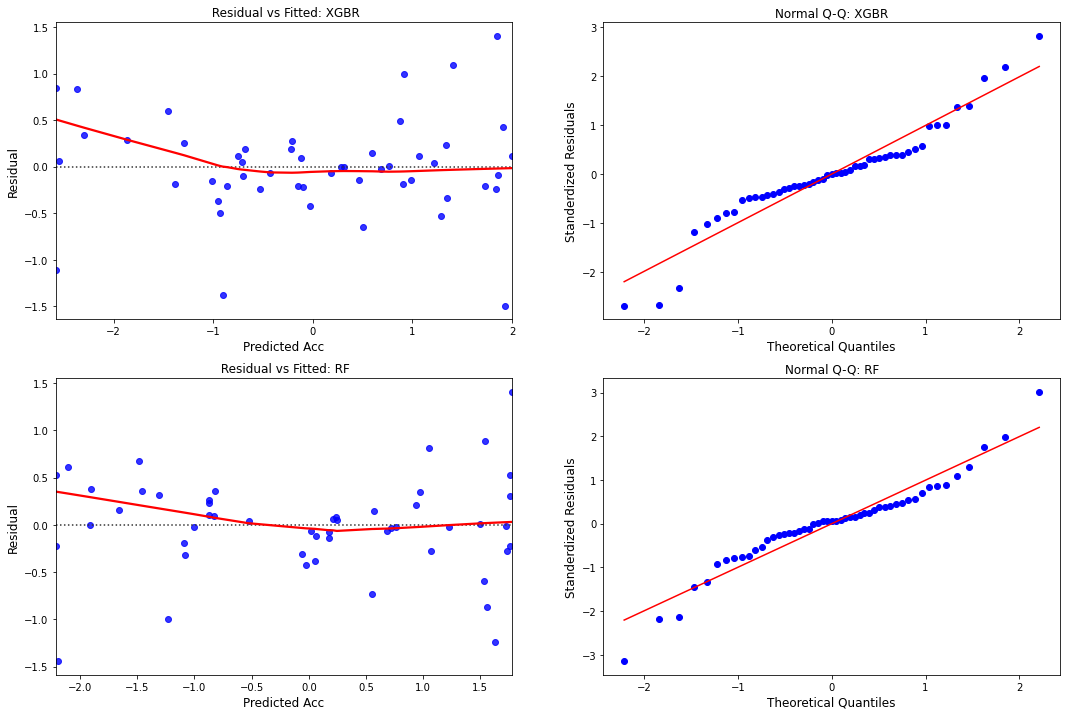

In [16]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
xgbr_res = np.array((y_test-xgbr_pred))
sns.residplot(xgbr_pred,xgbr_res,lowess = True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.ylabel("Residual",size=12)
plt.xlabel("Predicted Acc",size=12)
plt.title(" Residual vs Fitted: XGBR")

plt.subplot(2,2,2)
xgbr_stan = (xgbr_res - np.mean(xgbr_res))/np.std(xgbr_res)
stats.probplot(xgbr_stan, dist="norm", plot=pylab)
plt.title("Normal Q-Q: XGBR")
plt.ylabel("Standerdized Residuals",size=12)
plt.xlabel("Theoretical Quantiles",size=12)


plt.subplot(2,2,3)
rf_res = np.array((y_test-rf_pred))
sns.residplot(rf_pred,rf_res,lowess = True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.ylabel("Residual",size=12)
plt.xlabel("Predicted Acc",size=12)
plt.title(" Residual vs Fitted: RF")

plt.subplot(2,2,4)
rf_stan = (rf_res - np.mean(rf_res))/np.std(rf_res)
stats.probplot(rf_stan, dist="norm", plot=pylab)
plt.title("Normal Q-Q: RF")
plt.ylabel("Standerdized Residuals",size=12)
plt.xlabel("Theoretical Quantiles",size=12)

plt.show()

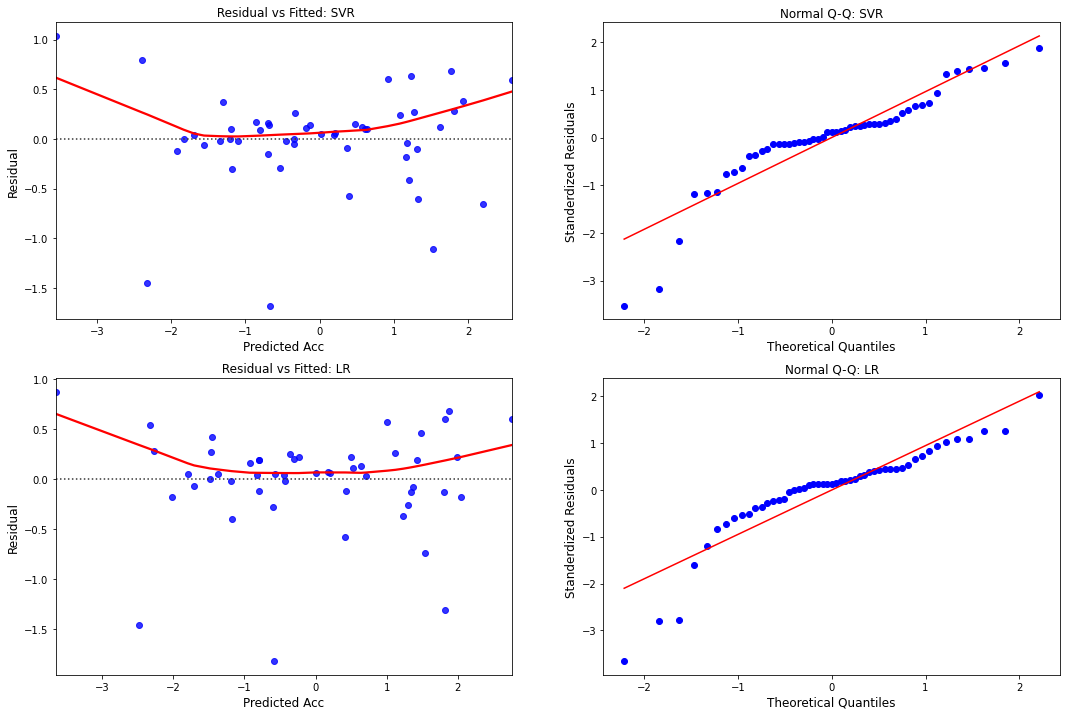

In [17]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
svr_res = np.array((y_test-svr_pred))
sns.residplot(svr_pred,svr_res,lowess = True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.ylabel("Residual",size=12)
plt.xlabel("Predicted Acc",size=12)
plt.title(" Residual vs Fitted: SVR")

plt.subplot(2,2,2)
svr_stan = (svr_res - np.mean(svr_res))/np.std(svr_res)
stats.probplot(svr_stan, dist="norm", plot=pylab)
plt.title("Normal Q-Q: SVR")
plt.ylabel("Standerdized Residuals",size=12)
plt.xlabel("Theoretical Quantiles",size=12)


plt.subplot(2,2,3)
lr_res = np.array((y_test-lr_pred))
sns.residplot(lr_pred,lr_res,lowess = True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.ylabel("Residual",size=12)
plt.xlabel("Predicted Acc",size=12)
plt.title(" Residual vs Fitted: LR")

plt.subplot(2,2,4)
lr_stan = (lr_res - np.mean(lr_res))/np.std(lr_res)
stats.probplot(lr_stan, dist="norm", plot=pylab)
plt.title("Normal Q-Q: LR")
plt.ylabel("Standerdized Residuals",size=12)
plt.xlabel("Theoretical Quantiles",size=12)

plt.show()

## Loading the unbinned models

In [18]:
xgbr = joblib.load('xgbr_unbin_com.pkl')
rf   = joblib.load('rf_unbin_com.pkl')
svr  = joblib.load('svr_unbin_com.pkl')
lr   = joblib.load('lr_unbin_com.pkl')

xgbr_pred   = xgbr.predict(X_test)
rf_pred     = rf.predict(X_test)
svr_pred    = svr.predict(X_test)
lr_pred     = lr.predict(X_test)

xgbr_train  = xgbr.predict(X_train)
rf_train    = rf.predict(X_train)
svr_train   = svr.predict(X_train)
lr_train    = lr.predict(X_train)


xgbr_R2_T   = xgbr.score(X_train,y_train)
xgbr_R2     = xgbr.score(X_test,y_test)
xgbr_RMSE   = mean_squared_error(y_test,xgbr_pred,squared=False)
xgbr_RMSE_T =mean_squared_error(y_train,xgbr_train,squared=False)
xgbr_MAE    = mean_absolute_error(y_test,xgbr_pred)
xgbr_MAE_T  = mean_absolute_error(y_train,xgbr_train)


rf_R2_T     = rf.score(X_train,y_train)
rf_R2       = rf.score(X_test,y_test)
rf_RMSE     = mean_squared_error(y_test,rf_pred,squared=False)
rf_RMSE_T   = mean_squared_error(y_train,rf_train,squared=False)
rf_MAE      = mean_absolute_error(y_test,rf_pred)
rf_MAE_T    = mean_absolute_error(y_train,rf_train)

svr_R2_T    = svr.score(X_train,y_train)
svr_R2      = svr.score(X_test,y_test)
svr_RMSE    = mean_squared_error(y_test,svr_pred,squared=False)
svr_RMSE_T  = mean_squared_error(y_train,svr_train,squared=False)
svr_MAE     = mean_absolute_error(y_test,svr_pred)
svr_MAE_T   = mean_absolute_error(y_train,svr_train)

lr_R2_T     = lr.score(X_train,y_train)
lr_R2       = lr.score(X_test,y_test)
lr_RMSE     = mean_squared_error(y_test,lr_pred,squared=False)
lr_RMSE_T   = mean_squared_error(y_train,lr_train,squared=False)
lr_MAE      = mean_absolute_error(y_test,lr_pred)
lr_MAE_T    = mean_absolute_error(y_train,lr_train)



dct = {}
dct['XGBR'] = [xgbr_R2_T,xgbr_R2,xgbr_RMSE_T,xgbr_RMSE,xgbr_MAE_T,xgbr_MAE]
dct['RF']   = [rf_R2_T,rf_R2,rf_RMSE_T,rf_RMSE,rf_MAE_T,rf_MAE]
dct['SVR']  = [svr_R2_T,svr_R2,svr_RMSE_T,svr_RMSE,svr_MAE_T,svr_MAE]
dct['LR']   = [lr_R2_T,lr_R2,lr_RMSE_T,lr_RMSE,lr_MAE_T,lr_MAE]

df_res = pd.DataFrame(dct).T
df_res.columns = ['Train_R2','Test_R2','Train_RMSE','Test_RMSE','Train_MAE','Test_MAE']
df_res

,Train_R2,Test_R2,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE
XGBR,0.717,0.682,0.765,0.824,0.573,0.660
RF,0.746,0.753,0.725,0.726,0.556,0.586
SVR,0.811,0.854,0.626,0.559,0.400,0.390
LR,0.814,0.856,0.621,0.554,0.436,0.386
